### CARGA DE LIBRERIAS

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

# preprocess & pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.cm as cm  
from sklearn.metrics import silhouette_samples, silhouette_score 
from scipy.sparse import hstack 

# modelos
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

# reducción / visualización
from sklearn.decomposition import PCA
import umap

# métricas de clustering (no requieren etiquetas)
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# utilidades gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

# para inspección de clusters
import scipy.cluster.hierarchy as sch
from scipy.sparse import save_npz

# correccion de columnas
import Funciones_limpieza as lmp


### Paleta de colores

In [1]:
palette_hospitality = [
    "#1F3C4B", "#2C6E91", "#6B8E23", "#4F7C6B",
    "#E6D5B8", "#D8CFC4", "#C97C5D", "#C9A24D",
    "#4A4A4A", "#9E9E9E", "#F7F4EF", "#1C1C1C",
    "#8B3A3A",  # rojo apagado
    "#6F8F72"   # verde oliva suave
]

# Tema base Seaborn (afecta también a matplotlib)
sns.set_theme(
    style="whitegrid",
    palette=palette_hospitality,
    rc={
        # Tamaño de figuras
        "figure.figsize": (10, 6),

        # Títulos y labels
        "axes.titlesize": 14,
        "axes.labelsize": 12,

        # Líneas
        "lines.linewidth": 2,

        # Grid
        "grid.alpha": 0.3,

        # Tipografía
        "font.size": 11
    }
)

# Asegurar que matplotlib use exactamente la misma paleta
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_hospitality)

NameError: name 'sns' is not defined

### CARGAMOS DATOS LIMPIOS CON NUEVAS COLUMNAS

In [20]:
ruta_csv = os.path.join("..", "Datos", "DatosTransformados", "df_limpio.csv")

# Cargar el CSV en un DataFrame
df = pd.read_csv(ruta_csv, true_values=['yes'], false_values=['no'],
    decimal='.', sep=',', thousands=',')

# Verificar que se cargó correctamente
df.head()

,booked_at,checkin_time,checkout_time,lead_time,lenght_of_stay,checkin_month,checkin_day,adult_count,child_count,origin,...,momento_checkin,ratio_asistencia,ratio_cancelaciones_mes_respecto_reservas,zona_roja,estacion_estancia,estacion_reserva,antiguedad_hotel_en_dias,es_festivo,es_finde,city
0,2022-11-26 16:10:00,2023-01-01 12:00:00,2023-01-02 12:00:00,36,1,January,Sunday,1,0,channel_manager,...,antes,1.000000,0.25171,1,invierno,otoño,2123,False,False,Donostia
1,2022-12-21 17:27:00,2023-01-01 13:09:00,2023-01-10 12:00:00,11,9,January,Sunday,1,0,channel_manager,...,antes,1.000000,0.25171,1,invierno,invierno,2123,True,False,Donostia
2,2022-09-21 19:46:00,2023-01-01 15:00:00,2023-01-07 12:00:00,102,6,January,Sunday,2,4,channel_manager,...,antes,0.333333,0.25171,1,invierno,otoño,2123,True,False,Donostia
3,2022-09-24 12:09:00,2023-01-01 15:00:00,2023-01-02 12:00:00,99,1,January,Sunday,2,2,channel_manager,...,antes,0.500000,0.25171,1,invierno,otoño,2123,False,False,Donostia
4,2022-10-18 07:12:00,2023-01-01 15:00:00,2023-01-02 12:00:00,75,1,January,Sunday,4,0,channel_manager,...,antes,1.000000,0.25171,1,invierno,otoño,2123,False,False,Donostia


### PREPARACIÓN DE DATOS PARA CLUSTERING

In [21]:
df.columns # STATUS Y HA CANCELADO ES LO MISMO SOLO QUE HA CANCELADO ES BOOLEANO, las columnas con las fechas no las vamos a utilizar


Index(['booked_at', 'checkin_time', 'checkout_time', 'lead_time',
       'lenght_of_stay', 'checkin_month', 'checkin_day', 'adult_count',
       'child_count', 'origin', 'travel_agency_name', 'requested_category',
       'requested_category_name', 'asset', 'asset_type', 'asset_opening_date',
       'available_units', 'business_segment', 'rate', 'rate_group_name',
       'rate_type', 'completed_entry_forms_count', 'all_entry_forms_completed',
       'returning_inhabitant', 'recurrence', 'libere_community',
       'bought_products', 'product_count', 'reservation_net_value',
       'total_adr', 'status', 'cancellation_reason', 'cancellation_lead_time',
       'ha_cancelado', 'momento_checkin', 'ratio_asistencia',
       'ratio_cancelaciones_mes_respecto_reservas', 'zona_roja',
       'estacion_estancia', 'estacion_reserva', 'antiguedad_hotel_en_dias',
       'es_festivo', 'es_finde', 'city'],
      dtype='object')

In [22]:
# vamos a extraer las columnas que utilizaremos para el clustering, tienen que ser columnas que no explican o que no indican si la reserva es cancelada, luego para el analisis utilizaremos todas
# de esta manera podemos utilizar el clustering para el modelado (si utilizamos columnas explicativas para el clustering y luego el clustering para el modelado, 'estamos dando pistas' al modelo)
df_clustering = df[['lead_time','lenght_of_stay','checkin_month','checkin_day','adult_count','child_count','origin',
                    'requested_category','asset','asset_type','business_segment','rate_type','returning_inhabitant','recurrence',
                    'libere_community','reservation_net_value',
                    'ratio_cancelaciones_mes_respecto_reservas','zona_roja','estacion_estancia','estacion_reserva','antiguedad_hotel_en_dias','es_festivo',
                    'es_finde','city']]

# completed entry forms count y all entry forms count no tiene sentido porque si lo ha cancelado es 0
# product count y si ha comprado tampoco porque todos los que han cancelado son 0

In [23]:
df_clustering.dtypes

lead_time                                      int64
lenght_of_stay                                 int64
checkin_month                                 object
checkin_day                                   object
adult_count                                    int64
child_count                                    int64
origin                                        object
requested_category                            object
asset                                         object
asset_type                                    object
business_segment                              object
rate_type                                     object
returning_inhabitant                            bool
recurrence                                     int64
libere_community                                bool
reservation_net_value                        float64
ratio_cancelaciones_mes_respecto_reservas    float64
zona_roja                                      int64
estacion_estancia                             

### 1. TRANSFORMACION DE COLUMNAS SEGUN SU TIPO PARA UTILIZAR EN CLUSTERING  

In [ ]:
lmp.detectar_tipos_columnas(df_clustering)
# guardamos cada elemento
tipos_columnas_transformados = lmp.detectar_tipos_columnas(df_clustering)
columnas_numericas = tipos_columnas_transformados['numericas']
columnas_categoricas = tipos_columnas_transformados['categoricas']
columnas_booleanas = tipos_columnas_transformados['booleanas']

df_clustering_transformado = tipos_columnas_transformados['dataframe_transformado']

c:\Users\maita\OneDrive\Escritorio\BDATA 2\RETO 6\CASOS PRACTICOS\RETO06_NARANJA\Scripts\Funciones_limpieza.py:56: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fechas = pd.to_datetime(serie, errors="coerce", infer_datetime_format=True)
c:\Users\maita\OneDrive\Escritorio\BDATA 2\RETO 6\CASOS PRACTICOS\RETO06_NARANJA\Scripts\Funciones_limpieza.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fechas = pd.to_datetime(serie, errors="coerce", infer_datetime_format=True)
c:\Users\maita\OneDrive\Escritorio\BDATA 2\RETO 6\CASOS PRACTICOS\RETO06_NARANJA\Scripts\Funciones_limpieza.py:56: UserWarning: The argument 'infer_datetime_format' is

### Convertir las columnas booleanas a numericas para utilizar en los algoritmos de clustering de distancias (k-means y clustering jerarquico)

In [27]:
for col in columnas_booleanas:
    df_clustering_transformado[col] = df_clustering_transformado[col].astype(int)
    columnas_numericas.append(col)
print(columnas_numericas) # ha cogido también las booleanas y convertido a 0 y 1 si hacia falta (la propia función también lo hace)

['lead_time', 'lenght_of_stay', 'adult_count', 'child_count', 'recurrence', 'reservation_net_value', 'ratio_cancelaciones_mes_respecto_reservas', 'antiguedad_hotel_en_dias', 'returning_inhabitant', 'libere_community', 'zona_roja', 'es_festivo', 'es_finde']


### Reducir cardinalidad para columnas categóricas grandes

In [28]:
# si en las columnas categoricas hay categorias que ocupan el 5% de los registros, los vamos a almacenar en otros para reducir cardinalidad

# vamos a analizar estas columnas categoricas (hay columnas categoricas que no tiene sentido reducir (checkin_month, estacion etc))

print(columnas_categoricas)
columnas_cat_analizar = ['origin', 'requested_category','business_segment','rate_type']

# Umbral mínimo de frecuencia (5%)
umbral = 0.05

for col in columnas_cat_analizar:
    # Calculamos frecuencia relativa de cada categoría
    freq = df_clustering_transformado[col].value_counts(normalize=True)
    
    # Categorías que cumplen el umbral
    categorias_frecuentes = freq[freq >= umbral].index
    
    # Reemplazamos las categorías raras o poco frecuentes por 'Otros'
    df_clustering_transformado[col] = df_clustering_transformado[col].where(df_clustering_transformado[col].isin(categorias_frecuentes), 'Otros')

print(df_clustering_transformado[columnas_cat_analizar])


['checkin_month', 'checkin_day', 'origin', 'requested_category', 'asset', 'asset_type', 'business_segment', 'rate_type', 'estacion_estancia', 'estacion_reserva', 'city']
                origin     requested_category    business_segment  \
0      channel_manager             Hostel bed  Leisure Individual   
1      channel_manager             Hostel bed  Leisure Individual   
2      channel_manager            Hostel room  Leisure Individual   
3      channel_manager            Hostel room  Leisure Individual   
4      channel_manager            Hostel room  Leisure Individual   
...                ...                    ...                 ...   
52445  channel_manager                  Otros  Leisure Individual   
52446        telephone  One bedroom apartment  Leisure Individual   
52447   direct_channel  Two bedroom apartment  Leisure Individual   
52448   direct_channel                  Otros  Leisure Individual   
52449   direct_channel                 Studio  Leisure Individual   

 

### CONVERTIR COLUMNAS CATEGORICAS A COLUMNAS DUMMY Y ESCALAR COLUMNAS NUMERICAS

#### Pipelines de transformación (funciones para aplicar a cada columna segun su tipo)

In [29]:
# pipeline para que para que todas las operaciones se apliquen siempre en el mismo orden
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # si hay NA (no hay en realidad pero porseacaso) que li impute con la mediana
    ("scaler", MinMaxScaler(feature_range=(0, 1)))# escalar los valores
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
]) # para las categoricas tanto con alta cardinalidad como con baja cardinalidad  si hay un valor NAN lo imputa con 'missing'
# porque imputarlo con la moda no tiene sentido ya que distorsiona la distribución.
# Es mejor representar explícitamente el valor nulo como otra categoría
# Luego para que los algoritmos puedan utilizar la columna convierte las categoricas a dummy o numericas con 0 y 1 (es más óptimo utilizar onehotencoder porque con handle_unknown='ignore'"Limpieza de datos.ipynb"
# es capaz de manejar categorias nuevas y poruqe es menos costoso computacionalmente hablando)


In [30]:
print(columnas_categoricas)

['checkin_month', 'checkin_day', 'origin', 'requested_category', 'asset', 'asset_type', 'business_segment', 'rate_type', 'estacion_estancia', 'estacion_reserva', 'city']


### ColumnTransformer: Aplicar esas transformaciones a las columnas

In [31]:
# definir a qué columnas se le aplica cada transformador que hemos definido anteriormente
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, columnas_numericas),
        ("cat_low", cat_transformer, columnas_categoricas)
    ],
    sparse_threshold=1.0   # fuerza salida en formato sparse
)


### Preprocesar X

In [33]:
X = preprocessor.fit_transform(df_clustering_transformado)

# # Convertir a dense SOLO si no es enorme
if hasattr(X, "toarray"):
    X = X.toarray().astype("float32")
    print('si hay que convertir a dense')

X.shape

si hay que convertir a dense


(52450, 81)

## Entrenar algoritmos

### K-means

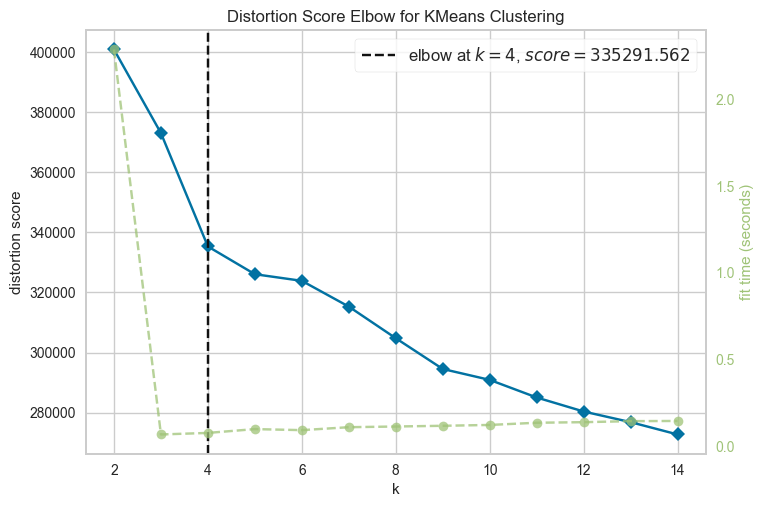

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
# ELEGIR PARAMETRO OPTIMO DE CLUSTERES

# DEFINIMOS SEMILLA
random_state = 42

# Crear modelo
model = KMeans(random_state=random_state)

# Crear visualizador
visualizer = KElbowVisualizer(
    model, 
    k=(2,15),       # rango de clusters a probar
    timings=True     # mostrar tiempo de ajuste
)

# Ajustar y mostrar
visualizer.fit(X)
visualizer.show() # parece que el numero de clusteres optimo es 4 pero vamos a probar con 4 y 5 

In [35]:
# PROBAMOS CON TRES K PARA LUEGO CALCULAR LA SILUETA Y ELEGIR EL NUMERO OPTIMO DE CLUSTERES
kmeans_4 = KMeans(n_clusters=4, random_state=random_state)
kmeans_5 = KMeans(n_clusters=5, random_state=random_state)

labels_kmeans_4 = kmeans_4.fit_predict(X)
labels_kmeans_5 = kmeans_5.fit_predict(X)


### CON EL METODO DE LA SILUETA CALCULAMOS PARA EVALUAR LOS MODELOS

In [36]:
# creamos función para poder evaluar distintos modelos

def evaluar_clustering(modelos_dict, X):
    """
    Evalúa distintos modelos de clustering con análisis de silueta y visualización.

    Argumentos:
        modelos_dict: dict
            Diccionario donde las claves son valores de n_clusters (o nombre),
            y los valores son tuplas (modelo, labels).
            Ejemplo: { 6: (kmeans_6, labels_kmeans_6), 7: (kmeans_7, labels_kmeans_7) }
        X: array-like, forma (n_samples, n_features)
            Datos usados para el clustering (para silueta y graficar).

    Producción:
        Para cada modelo, imprime el silhouette average y muestra dos gráficos:
            - silhouette plot
            - visualización de los clusters + centroides (si tiene centroides)
    """
    # Iteramos por cada par (clave, (modelo, etiquetas)) en el diccionario
    for key, (modelo, labels) in modelos_dict.items():
        # Número de clusters detectados (etiquetas únicas)
        n_clusters = len(np.unique(labels))
        print(f"\n=== Modelo: {key} (n_clusters = {n_clusters}) ===")

        # Creamos figura con 2 subplots en una fila
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)  # tamaño de la figura

        # — Configuración del gráfico de silueta —
        ax1.set_xlim([-0.1, 1])  # rango eje X para coeficientes de silueta
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])  # rango eje Y con margen para clusters

        # Calculamos el promedio del coeficiente de silueta para todas las muestras
        silhouette_avg = silhouette_score(X, labels)
        print(f"Silhouette average: {silhouette_avg:.4f}")

        # Calculamos el valor del coeficiente de silueta para cada muestra individualmente
        sample_silhouette_values = silhouette_samples(X, labels)

        y_lower = 10  # posición inicial en Y para dibujar cada cluster
        for i in range(n_clusters):
            # Valores de silueta para el cluster i
            ith_vals = sample_silhouette_values[labels == i]
            ith_vals.sort()  # ordenar para mejor visualización
            size_cluster = ith_vals.shape[0]  # número de puntos en el cluster
            y_upper = y_lower + size_cluster  # límite superior para rellenar en Y

            # Elegimos color del cluster usando colormap
            color = cm.nipy_spectral(float(i) / n_clusters)

            # Dibujamos área rellena para este cluster
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),  # rango en Y
                0,                           # desde 0 en X
                ith_vals,                    # hasta el valor de silueta
                facecolor=color,
                edgecolor=color,
                alpha=0.7
            )

            # Etiqueta cluster en el gráfico, ligeramente a la izquierda
            ax1.text(-0.05, y_lower + 0.5 * size_cluster, str(i))

            # Actualizamos y_lower para el siguiente cluster, dejando espacio
            y_lower = y_upper + 10

        # Etiquetas y formato del gráfico de silueta
        ax1.set_title("Silhouette plot")
        ax1.set_xlabel("Silhouette coefficient")
        ax1.set_ylabel("Cluster")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")  # línea media promedio
        ax1.set_yticks([])  # sin ticks en Y para limpiar visual
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])  # ticks X definidos

        # — Scatter plot con los datos y clusters —
        colors = cm.nipy_spectral(labels.astype(float) / n_clusters)  # colores según cluster

        ax2.scatter(
            X[:, 0], X[:, 1],  # dos primeras características para graficar (asume 2D)
            marker='.',
            s=30,
            lw=0,
            alpha=0.7,
            c=colors,
            edgecolor='k'  # borde negro en puntos para mejor visibilidad
        )

        # Si el modelo tiene centroides (como KMeans), dibujarlos
        if hasattr(modelo, "cluster_centers_"):
            ax2.scatter(
                modelo.cluster_centers_[:, 0],
                modelo.cluster_centers_[:, 1],
                marker='o',
                c="white",
                alpha=1,
                s=300,
                edgecolor='k'
            )
            # Numerar centroides con su índice
            for i, c in enumerate(modelo.cluster_centers_):
                ax2.scatter(c[0], c[1], marker=f'${i}$', s=50, edgecolor='k')

        # Etiquetas y título scatter plot
        ax2.set_title("Clustered data visualization")
        ax2.set_xlabel("Feature 1")
        ax2.set_ylabel("Feature 2")

        # Título general de la figura
        plt.suptitle(f"Silhouette analysis — Modelo: {key}", fontsize=14, fontweight='bold')

        # Mostrar figura
        plt.show()



=== Modelo: 4 (n_clusters = 4) ===
Silhouette average: 0.1555


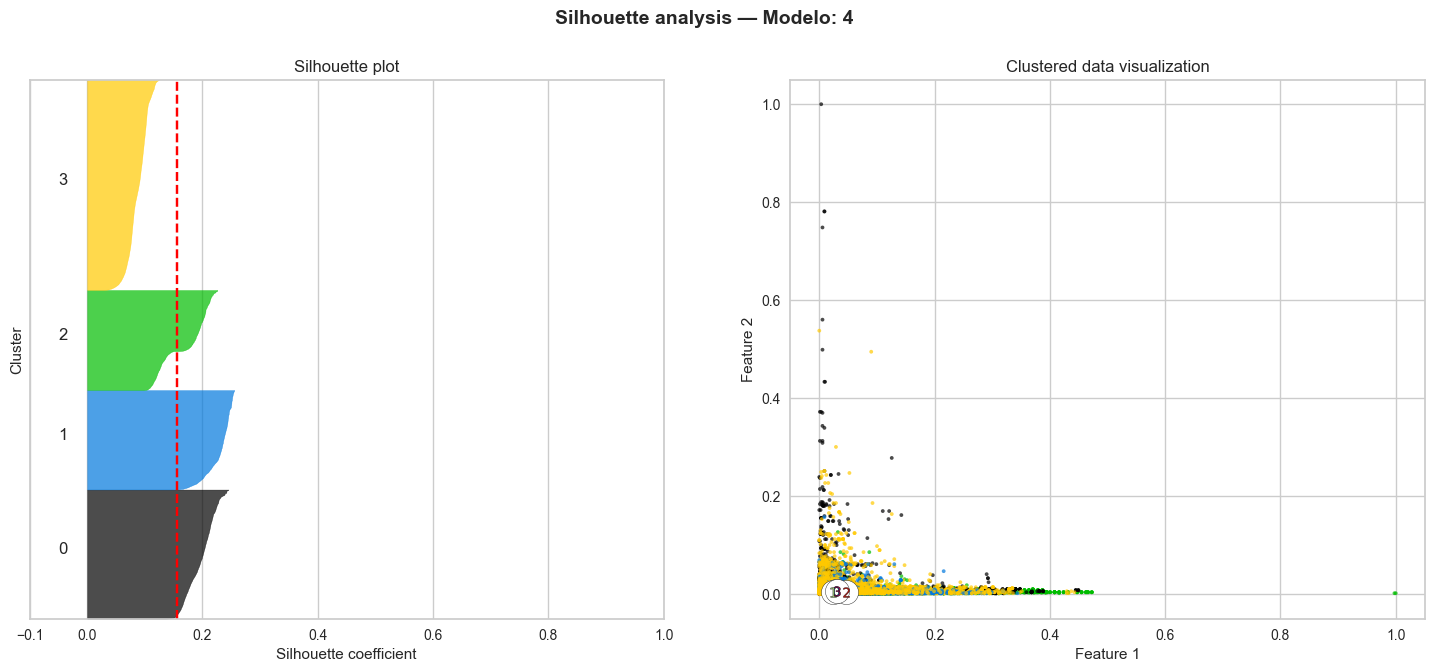


=== Modelo: 5 (n_clusters = 5) ===
Silhouette average: 0.1398


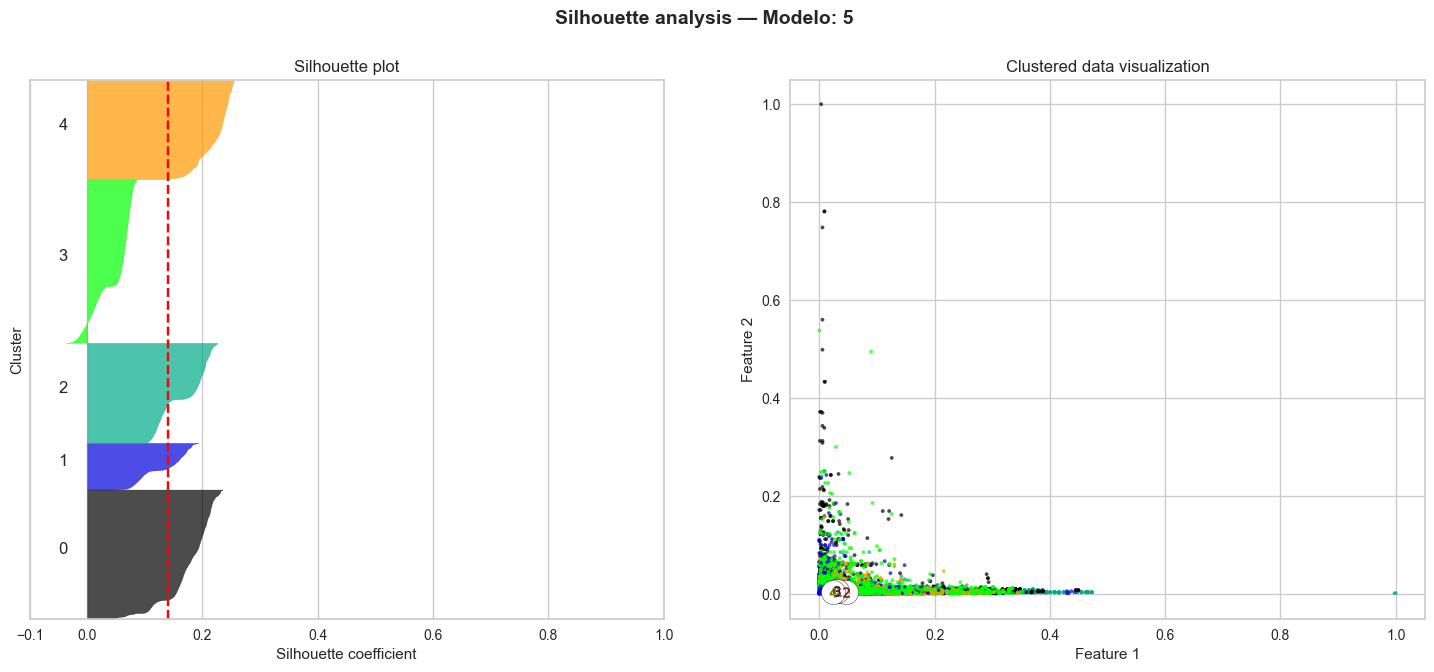

In [37]:
# utilizamos función para evaluar modelos con distinos numeros de clusteres con el algoritmo k means
modelos_kmeans = {
    4: (kmeans_4, labels_kmeans_4),
    5: (kmeans_5, labels_kmeans_5)
}

evaluar_clustering(modelos_kmeans, X)

### numero ópitmo de clusteres en k means es 4

### DBSCAN

#### Elegir parametros optimos:
eps → radio máximo para considerar vecinos

min_samples → mínimo de puntos en un vecindario para ser "núcleo"

### Para elegir estos paremtros se va a utilizar el metodo de distancias k-esimas
- Para cada punto, calcular la distancia al min_samples-ésimo vecino más cercano.

- Ordenar esas distancias de menor a mayor.

- Graficar esa curva.

- Buscar el codo (“elbow”), que marca una subida brusca → ese valor es un buen candidato para ep

Min_samples estimados: [157, 162, 167]

Calculando eps óptimo para min_samples = 157 ...


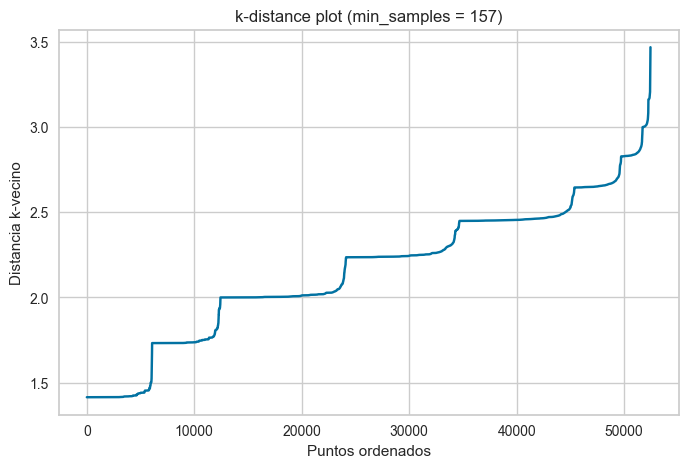

 → Epsilon recomendado = 3.3993

Calculando eps óptimo para min_samples = 162 ...


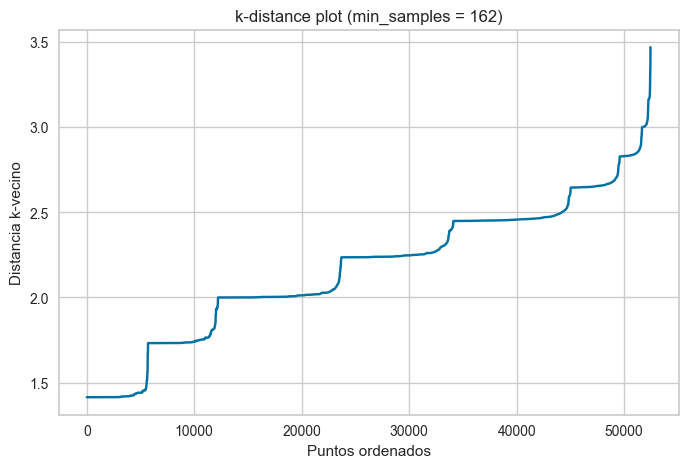

 → Epsilon recomendado = 3.3998

Calculando eps óptimo para min_samples = 167 ...


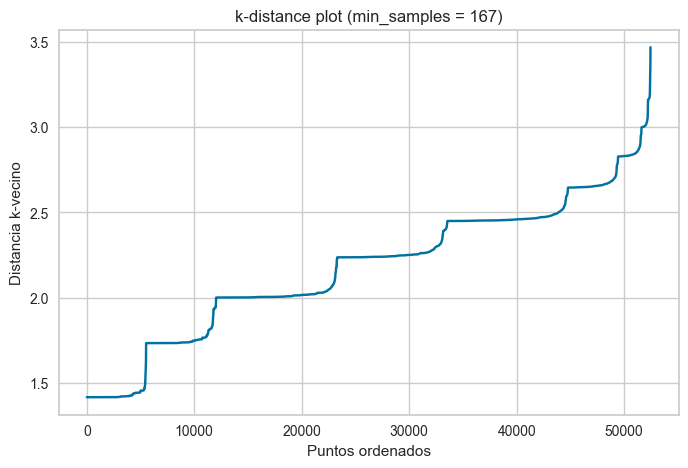

 → Epsilon recomendado = 3.4003

Resumen: mejores eps para min_samples
min_samples = 157 → eps = 3.3993
min_samples = 162 → eps = 3.3998
min_samples = 167 → eps = 3.4003


In [38]:
# Se va a calcular el min_samples optimo dependiendo de la cantidad de datos que tenemos, se va a elegir ese numero, cinco unidades menos y cinco unidades más para 
# evaluar diferentes min_samples. Para cada min_sample se va a calcular el epsilon óptimo utilizando el metodo de distancias k-esimas. Así tendremos
# tres modelos de DBSCAn para comparar y elegir el mejor (dependiendo del coeficiente de la silueta)


# ============================
# 1. calcular min_samples óptimo
# ============================

n_features = X.shape[1]
min_samples_opt = max(2, 2 * n_features)  # regla estándar
min_samples_values = [min_samples_opt - 5, min_samples_opt, min_samples_opt + 5]

print("Min_samples estimados:", min_samples_values)

# ===============================================
# 2. Función para calcular el eps óptimo (knee)
# ===============================================

def calcular_eps_optimo(X, min_samples):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X)
    
    distancias, _ = neigh.kneighbors(X)
    k_dist = np.sort(distancias[:, -1])

    # Graficar k-distance plot
    plt.figure(figsize=(8,5))
    plt.plot(k_dist)
    plt.title(f'k-distance plot (min_samples = {min_samples})')
    plt.xlabel("Puntos ordenados")
    plt.ylabel("Distancia k-vecino")
    plt.grid(True)
    plt.show()

    # Detección aproximada del codo (índice del mayor cambio)
    dif = np.diff(k_dist)
    knee_index = np.argmax(dif)
    eps_optimo = k_dist[knee_index]

    return eps_optimo

# =================================================
# 3. Calcular eps óptimo para cada min_samples
# =================================================

eps_recomendados = {}

for ms in min_samples_values:
    print(f"\nCalculando eps óptimo para min_samples = {ms} ...")
    eps = calcular_eps_optimo(X, ms)
    eps_recomendados[ms] = eps
    print(f" → Epsilon recomendado = {eps:.4f}")

# Mostrar resumen final
print("\n====================================")
print("Resumen: mejores eps para min_samples")
print("====================================")
for ms, eps in eps_recomendados.items():
    print(f"min_samples = {ms} → eps = {eps:.4f}")


### Utilizamos estos parametros para crear los modelos

In [39]:
# epsilon es el mismo para todos
dbscan_157 = DBSCAN(eps=3.3871, min_samples=157)
# dbscan_482 = DBSCAN(eps=0.1, min_samples = 482)
# dbscan_487 = DBSCAN(eps=0.1, min_samples = 487)

labels_dbscan_157 = dbscan_157.fit_predict(X)
print(np.unique(labels_dbscan_157)) # no crea clusteres, probar con distintos min_samples y epsilons
# labels_dbscan_482 = dbscan_482.fit_predict(X)
# labels_dbscan_487 = dbscan_487.fit_predict(X)


[0]


Probar con min_samples mas pequeños y epsilon

ε define qué tan cerca tienen que estar los puntos para considerarse “juntos”.

ε pequeño → muchos puntos aislados → mucho ruido

ε grande → clusters muy grandes o todos unidos

min_samples define qué tan densa debe ser una región para formar un cluster.

min_samples alto → clusters más densos, más ruido

min_samples bajo → clusters más pequeños, menos ruido

In [40]:
dbscan_30 = DBSCAN( metric="euclidean",
    eps=2,
    min_samples=30)
labels_30 = dbscan_30.fit_predict(X)
print(np.unique(labels_30))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


In [41]:
silueta_30 = silhouette_score(
    X,
    labels_30,
    metric='euclidean' )
print(silueta_30)



0.10348708927631378


In [42]:
dbscan_40 = DBSCAN( metric="euclidean",
    eps=2.1,
    min_samples=40)
labels_40 = dbscan_40.fit_predict(X)
print(np.unique(labels_40)) # [-1  0  1  2  3]

[-1  0  1  2  3]


In [43]:
dbscan_40_silueta = silhouette_score(
    X,
    labels_40,
    metric='euclidean' )
print(dbscan_40_silueta) # 0.1493392288684845 --> MEJOR MODELO QUE SE A ENCONTRADO CON DBSCAN

0.1493392288684845


# Clustering jerarquico con distancia euclidea y metodo = complete

### Dibujamos dendograma y elegimos numero de clusteres optimo

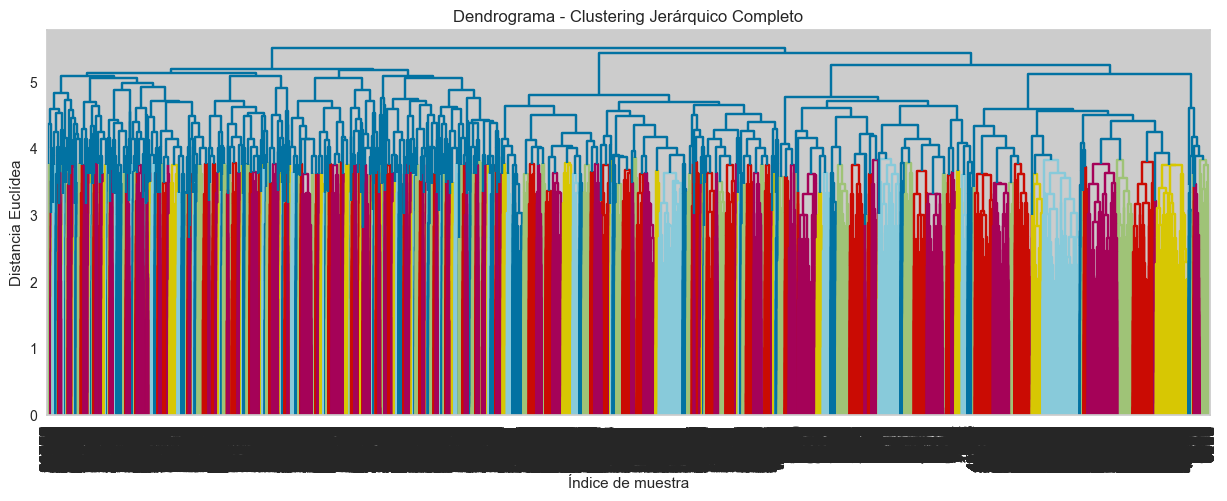

In [44]:
# Calculamos la matriz de linkage usando distancia euclídea y método 'complete'
Z = linkage(X, method='complete', metric='euclidean')

# Dibujamos el dendrograma
plt.figure(figsize=(15, 5))
dendrogram(Z, leaf_rotation=90, leaf_font_size=12)
plt.title("Dendrograma - Clustering Jerárquico Completo")
plt.xlabel("Índice de muestra")
plt.ylabel("Distancia Euclídea")
plt.show()

# PARECE QUE EL NUMERO OPTIMO DE CLUSTER ES 3,4 O 5

Teniendo en cuenta el dendograma vamos a probar con estos numeros de clusters

Para n_clusters = 3, media silueta = 0.1410


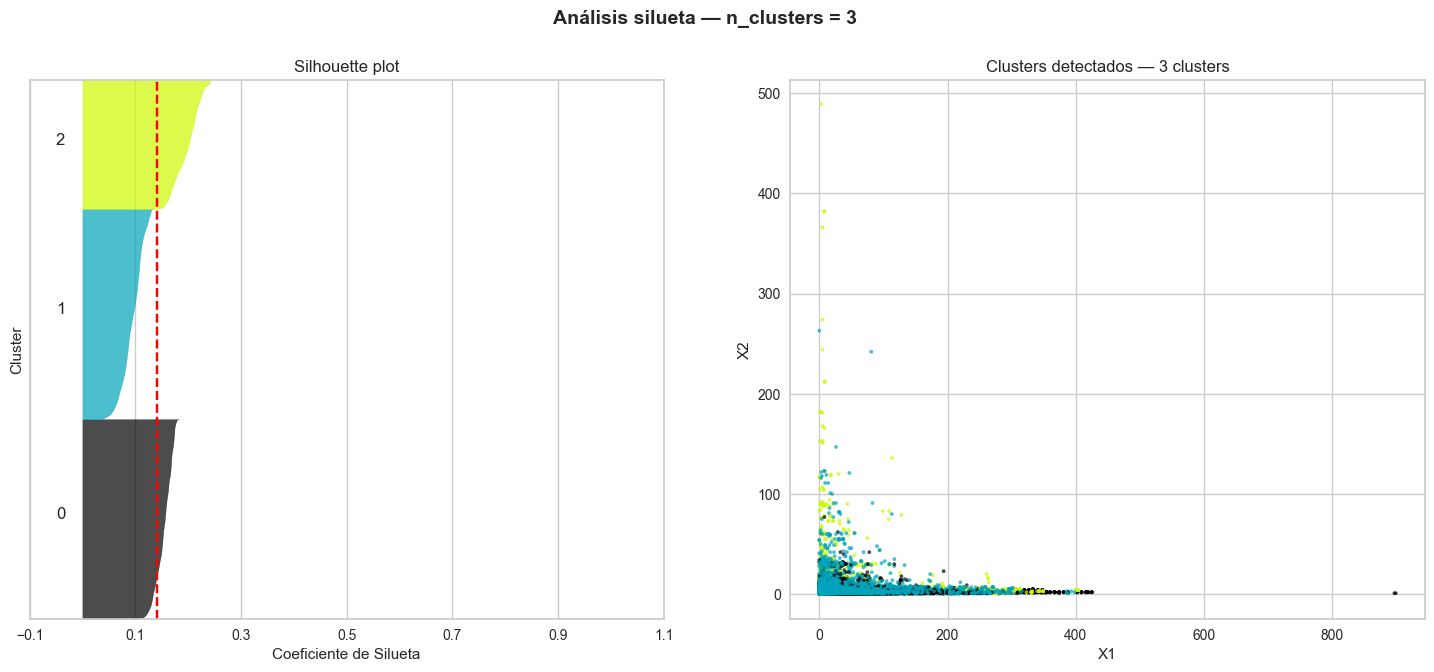

Para n_clusters = 4, media silueta = 0.1479


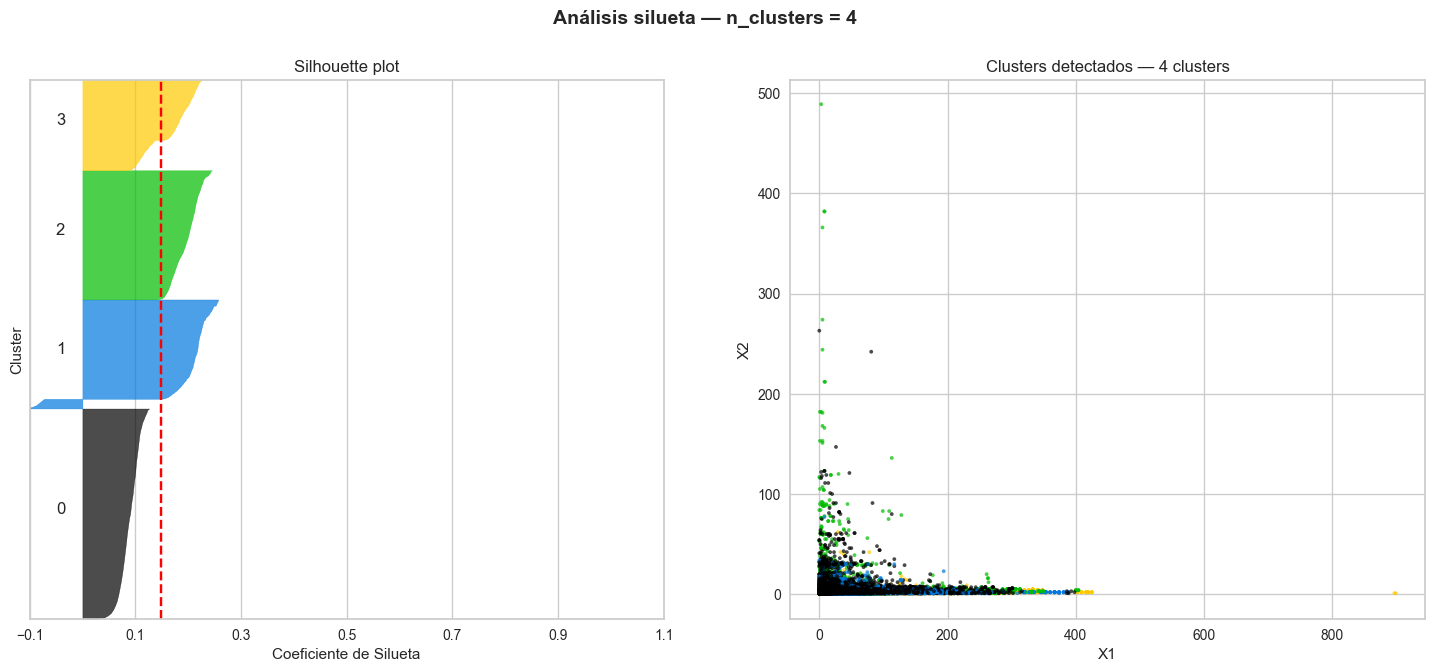

Para n_clusters = 5, media silueta = 0.1269


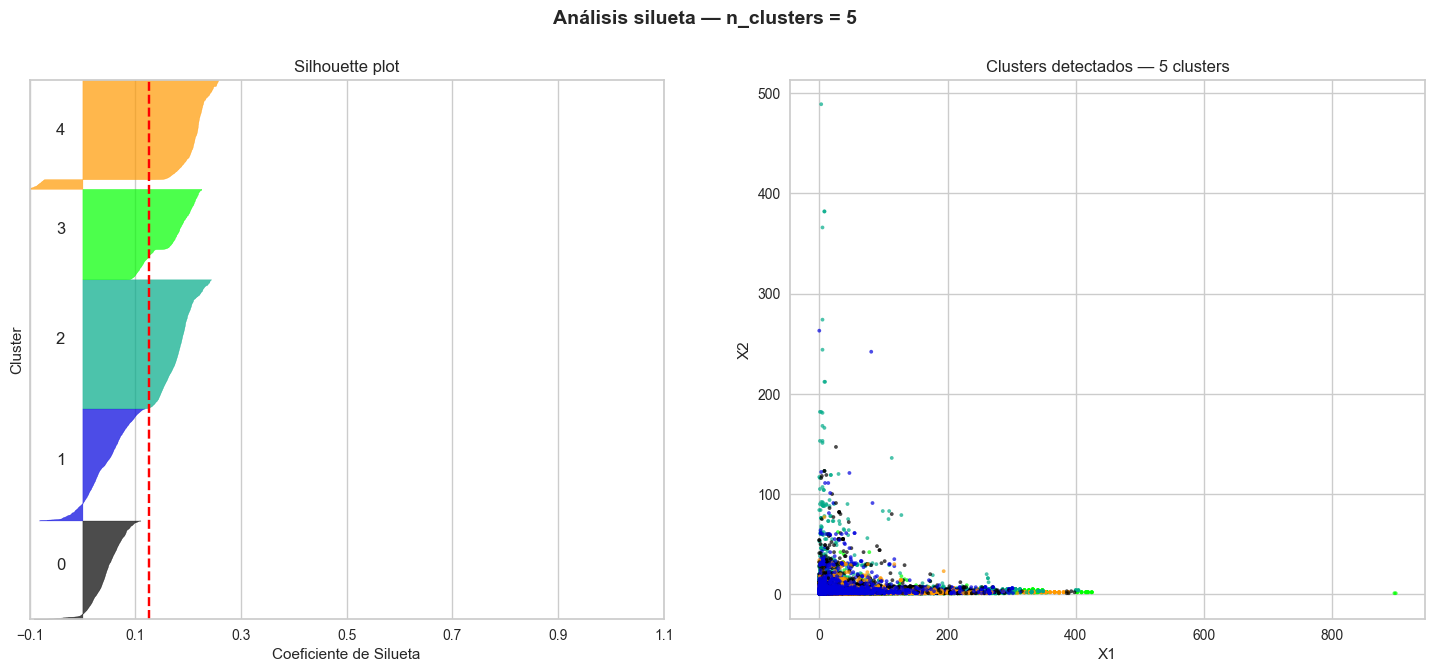

In [45]:
range_n_clusters = [ 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))

    clusterer = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
    cluster_labels = clusterer.fit_predict(X)

    # Silueta
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, media silueta = {silhouette_avg:.4f}")
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # ---------- grafico silueta ----------
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Coeficiente de Silueta")
    ax1.set_ylabel("Cluster")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    # ---------- Scatter plot X1 vs X2 ----------
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df_clustering.iloc[:,0], df_clustering.iloc[:,1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    ax2.set_title(f"Clusters detectados — {n_clusters} clusters")
    ax2.set_xlabel("X1")
    ax2.set_ylabel("X2")

    plt.suptitle(f"Análisis silueta — n_clusters = {n_clusters}", fontsize=14, fontweight='bold')
    plt.show()

### ELEGIMOS N_CLUSTER=4 (COEF DE SILUETA MAS GRANDE)

In [46]:
jerarquico_n_4 = AgglomerativeClustering(
    n_clusters=4,
    linkage="complete",
    metric="euclidean"
)
labels_jerarquico_n_4 = jerarquico_n_4.fit_predict(X)

# Evaluar todos los modelos

Numero de clusteres (ignora ruido en DBSCAN)

In [47]:
def num_clusters(labels):
    unique = set(labels)
    return len(unique) - (1 if -1 in unique else 0)


Distancia intra-cluster media (entre puntos del mismo cluster)

In [48]:
def intra_cluster_distance(X, labels):
    distances = []

    for label in set(labels):
        if label == -1:
            continue  # ignorar ruido

        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            dists = pairwise_distances(cluster_points)
            distances.append(np.mean(dists))

    return np.mean(distances) if distances else np.nan


Distancia inter-cluster media (entre centroides)

In [49]:
def inter_cluster_distance(X, labels):
    centroids = []

    for label in set(labels):
        if label == -1:
            continue
        centroids.append(X[labels == label].mean(axis=0))

    if len(centroids) < 2:
        return np.nan

    centroid_distances = pairwise_distances(centroids)
    return np.mean(centroid_distances)


Funcion general de evaluacion

In [50]:
def evaluate_clustering(X, labels, algorithm_name):
    n_clusters = num_clusters(labels)

    # Silhouette solo si hay ≥ 2 clusters y no todo es ruido
    if n_clusters >= 2:
        sil_score = silhouette_score(X, labels)
    else:
        sil_score = np.nan

    return {
        "Algoritmo": algorithm_name,
        "Nº Clusters": n_clusters,
        "Silhouette": sil_score,
        "Distancia intra-cluster": intra_cluster_distance(X, labels),
        "Distancia inter-cluster": inter_cluster_distance(X, labels)
    }


Aplicar a los modelos realizados

In [52]:
results = []

results.append(evaluate_clustering(X, labels_kmeans_4, "K-Means"))
results.append(evaluate_clustering(X, labels_jerarquico_n_4, "Clustering Jerárquico"))
results.append(evaluate_clustering(X, labels_40, "DBSCAN"))

results_df = pd.DataFrame(results)
results_df

,Algoritmo,Nº Clusters,Silhouette,Distancia intra-cluster,Distancia inter-cluster
0,K-Means,4,0.155501,3.440374,1.858619
1,Clustering Jerárquico,4,0.147908,3.467384,1.823570
2,DBSCAN,4,0.149339,3.429945,1.860313


In [58]:
results_df['Parametros'] = ['-','Distancia = Euclidea, metodo = complete', 'min_samples = 40, epsilon = 2.1']
orden_columnas = [
    'Algoritmo',
    'Parametros',
    'Nº Clusters',
    'Silhouette',
    'Distancia intra-cluster',
    'Distancia inter-cluster'
]

results_df = results_df[orden_columnas]


In [59]:
results_df

,Algoritmo,Parametros,Nº Clusters,Silhouette,Distancia intra-cluster,Distancia inter-cluster
0,K-Means,-,4,0.155501,3.440374,1.858619
1,Clustering Jerárquico,"Distancia = Euclidea, metodo = complete",4,0.147908,3.467384,1.823570
2,DBSCAN,"min_samples = 40, epsilon = 2.1",4,0.149339,3.429945,1.860313


In [60]:

results_df.to_csv("../Datos/Resultados/comparacion_metricas_clustering.csv", index=False)

## Clustering jerarquico es el mejor --> añadimos los clusteres al df original y al df que utilizaremos para el modelado

In [61]:
df['clusters'] = labels_jerarquico_n_4
display(df)


,booked_at,checkin_time,checkout_time,lead_time,lenght_of_stay,checkin_month,checkin_day,adult_count,child_count,origin,...,ratio_asistencia,ratio_cancelaciones_mes_respecto_reservas,zona_roja,estacion_estancia,estacion_reserva,antiguedad_hotel_en_dias,es_festivo,es_finde,city,clusters
0,2022-11-26 16:10:00,2023-01-01 12:00:00,2023-01-02 12:00:00,36,1,January,Sunday,1,0,channel_manager,...,1.000000,0.251710,1,invierno,otoño,2123,False,False,Donostia,3
1,2022-12-21 17:27:00,2023-01-01 13:09:00,2023-01-10 12:00:00,11,9,January,Sunday,1,0,channel_manager,...,1.000000,0.251710,1,invierno,invierno,2123,True,False,Donostia,3
2,2022-09-21 19:46:00,2023-01-01 15:00:00,2023-01-07 12:00:00,102,6,January,Sunday,2,4,channel_manager,...,0.333333,0.251710,1,invierno,otoño,2123,True,False,Donostia,3
3,2022-09-24 12:09:00,2023-01-01 15:00:00,2023-01-02 12:00:00,99,1,January,Sunday,2,2,channel_manager,...,0.500000,0.251710,1,invierno,otoño,2123,False,False,Donostia,3
4,2022-10-18 07:12:00,2023-01-01 15:00:00,2023-01-02 12:00:00,75,1,January,Sunday,4,0,channel_manager,...,1.000000,0.251710,1,invierno,otoño,2123,False,False,Donostia,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52445,2023-10-10 20:53:00,2023-12-31 15:00:00,2024-01-01 11:00:00,82,1,December,Sunday,4,0,channel_manager,...,NaN,0.239724,0,invierno,otoño,1211,False,False,Pamplona,0
52446,2023-10-13 13:38:00,2023-12-31 15:00:00,2024-01-01 11:00:00,79,1,December,Sunday,4,0,telephone,...,1.000000,0.239724,0,invierno,otoño,1211,False,False,Pamplona,0
52447,2023-10-17 08:36:00,2023-12-31 15:00:00,2024-01-01 11:00:00,75,1,December,Sunday,5,0,direct_channel,...,1.000000,0.239724,0,invierno,otoño,1211,False,False,Pamplona,0
52448,2023-10-17 08:36:00,2023-12-31 15:00:00,2024-01-01 11:00:00,75,1,December,Sunday,4,0,direct_channel,...,1.000000,0.239724,0,invierno,otoño,1211,False,False,Pamplona,0


Guardamos en resultados

In [62]:
df.to_csv("../Datos/Resultados/df_con_clusters_asignados.csv", index=False)